# Clustering of bike accident locations

In [1]:
import pandas as pd
import numpy as np
import requests
import folium
import config
from math import radians, cos, sin, asin, sqrt
import os.path
from functools import partial
import pyproj
import math
import csv

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import asPolygon
from shapely.geometry import asLineString
from shapely.ops import transform
from shapely.ops import cascaded_union
from shapely.geometry import Point
import geopandas as gpd
import mplleaflet

# scaling
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# models
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
import scipy

In [2]:
#load preprocessed data frame with 2018-2020 data
df = pd.read_csv('../raw_data/df_LOR_2021.csv', index_col=False)

In [3]:
df.head()

district        LOR                                             street  \
0         3  3020209.0                                  Niederschönhausen   
1         3  3071639.0                                       Bötzowstraße   
2         2  2050602.0                                   Samariterviertel   
3         1  1011204.0  Leipziger Straße                              ...   
4         9  9020601.0  Schnellerstraße                               ...   

    LOR_2021  year  month  hour  weekday  category  accident_kind  ...  car  \
0  3200206.0  2018      1    15        4         3              6  ...    0   
1  3701660.0  2018      1    11        5         3              5  ...    1   
2  2500729.0  2018      1     8        2         3              5  ...    1   
3  1100207.0  2018      1    19        4         3              5  ...    1   
4  9200613.0  2018      1    18        4         2              5  ...    1   

   pedestrian  motorcycle  goods_vehicle  others  road_condition      LINREFX  \
0           1           0              0       0               1  798261.3849   
1           0           0              0       0               1  800551.7210   
2           0           0              0       0               0  803320.7292   
3           0           0              0       0               1  798174.6913   
4           0           0              0       0               1  806109.6297   

       LINREFY  XGCSWGS84  YGCSWGS84  
0  5835047.260  13.403228  52.583472  
1  5829808.492  13.432186  52.535255  
2  5827627.446  13.470897  52.514173  
3  5826939.978  13.394673  52.510848  
4  5821644.404  13.506372  52.458993  

[5 rows x 22 columns]

<AxesSubplot:xlabel='hour', ylabel='Count'>

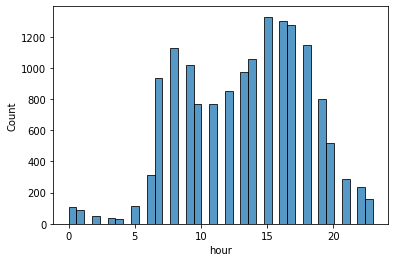

In [4]:
sns.histplot(df['hour'])

In [ ]:
#plt.scatter(x=df['XGCSWGS84'], y= df['YGCSWGS84'])

In [ ]:
#sns.histplot(x = df['LINREFX'])

In [ ]:
#sns.histplot(x = df['LINREFY'])

In [ ]:
# don't need to scale! instantiating scaler
# scaler = StandardScaler()

In [ ]:
#scaler.fit(df[['XGCSWGS84']])

In [ ]:
# df['XGCSWGS84'] = scaler.transform(df[['XGCSWGS84']])

In [ ]:
#scaler2 = StandardScaler()

In [ ]:
#scaler2.fit(df[['YGCSWGS84']])

In [ ]:
#df['YGCSWGS84'] = scaler2.transform(df[['YGCSWGS84']])

In [ ]:
#plt.scatter(x=df['XGCSWGS84'], y= df['YGCSWGS84'])

## K-Means

In [ ]:
%%time
# elbow method for number of clusters

X = df[["LINREFX","LINREFY"]]
max_k = 100

## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model= KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)

## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
%%time

k = 2000
model = KMeans(n_clusters=k, init='k-means++')
X = df[["LINREFX","LINREFY"]]

## clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)

## find centroids (the datapoints closest to the center)
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
df[["cluster_km","centroids_km"]] = df_X[["cluster","centroids"]]
df.sample(5)

In [ ]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="LINREFX", y="LINREFY", data=df, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False, ax=ax).set_title('Clustering(k='+str(k)+')')
                                                 
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

In [ ]:
# df that contains only centroids for mappinig

df_kmeans_cluster = df[df['centroids'] == 1]

df_kmeans_cluster.head()

## Affinity propagation

In [ ]:
%%time

model = AffinityPropagation()
X = df[["LINREFX","LINREFY"]]

## clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)

## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
df[["cluster_ap","centroids_ap"]] = df_X[["cluster","centroids"]]
df.sample(5)

In [ ]:
#model = AffinityPropagation()

In [ ]:
#model, dtf_X = fit_ml_cluster(X=df[["XGCSWGS84","YGCSWGS84"]], model=model, figsize=(10,5))

In [ ]:
'''
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="LINREFX", y="LINREFY", data=df, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False, ax=ax).set_title('Clustering(k='+str(k)+')')
                                                 
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")
''';

## DBSCAN

In [5]:
# find clusters using DB_SCAN (density based)




In [6]:
# create_radian_columns(df):

df['rad_lng'] = np.radians(df['XGCSWGS84'].values)
df['rad_lat'] = np.radians(df['YGCSWGS84'].values)

In [7]:
# find clusters with DBSCAN:

eps_in_meters = 25 # hotspot area
num_samples = 5 # accidents in cluster
earth_perimeter = 40070000.0  # In meters
eps_in_radians = eps_in_meters / earth_perimeter * (2 * math.pi)
db_scan = DBSCAN(eps=eps_in_radians, min_samples=num_samples, metric='haversine')
df['Cluster'] = db_scan.fit_predict(df[['rad_lat', 'rad_lng']])

In [8]:
def buffer_in_meters(lng, lat, radius):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    
    return buffer_latlng
    

In [ ]:
#def create_point(row):
#    return Point(row['Longitude'], row['Latitude'])

In [ ]:
#def write_line_string(file_name, hull):
#    with open("data/out/{0}.csv".format(file_name), "w") as file:
#        file.write('\"line\"\n')
#        text = hull.wkt
#        file.write('\"' + text + '\"\n')

In [9]:
# Group the observations by cluster identifier

#def generate_blob_clusters(df, eps_in_meters=50):

groups = df.groupby('Cluster')
clusters = list()
blobs = list()
counts = list()
    
for cluster_id, points in groups:
    if cluster_id >= 0:
        buffer_radius = eps_in_meters #* 0.6
        buffers = [buffer_in_meters(lon, lat, buffer_radius)for lon, lat in zip(points['XGCSWGS84'], points['YGCSWGS84'])]
        blob = cascaded_union(buffers)
        blobs.append(blob)
        clusters.append(cluster_id)
        counts.append(len(points))
            
# Create the GeoDataFrame from the cluster numbers and blobs
data = {'cluster': clusters, 'polygon': blobs, 'count': counts}
cluster_gdf = gpd.GeoDataFrame(pd.DataFrame(data), geometry='polygon')
cluster_gdf.crs = {'init': 'epsg:4326'}

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is d

/tmp/ipykernel_904/3630490427.py:14: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  blob = cascaded_union(buffers)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-chan

/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/supersakul/.pyenv/versions/3.8.12/envs/berlin-bike-theft-forecasting/lib/python3.8/site-packag

In [29]:
cluster_gdf['count'].value_counts()

5     146
6      86
7      52
8      48
9      33
10     21
11     14
12     10
13      9
15      7
14      7
17      4
18      3
20      3
22      3
19      3
16      2
25      1
30      1
Name: count, dtype: int64

In [22]:
cluster_gdf = cluster_gdf[cluster_gdf['count'] > 4]

In [25]:
cluster_gdf.to_pickle('../raw_data/B_Accident_data/cluster_gdf.pickle')

In [ ]:
##density = (df
##    .reset_index()
##    .rename(columns={'Id': 'Count'})
##    .groupby('Postcode cijfers')
##    .count()
##)[['Count']].reset_index()
#
#
#
#choropleth = folium.Choropleth('../Resources/PC4_BUURTEN.json',
#                  name='Accident count',
#                  data=cluster_gdf,
#                  key_on='properties.Postcode4',
#                  columns=['Count'],
#                  fill_color='YlGn',
#                  fill_opacity=0.7,
#                  line_opacity=0.2,
#                  legend_name='Customer Count',
#).add_to(m)
#
#choropleth.geojson.add_child(
#    folium.features.GeoJsonTooltip(['Postcode4'])
#)

In [11]:
#plotting the hotspots in folium
m = folium.Map(location=[52.52000, 13.4050],tiles='openstreetmap', zoom_start=12)
folium.features.GeoJson(cluster_gdf,
                        style_function= lambda x: {'fillColor': 'red', 'color': 'red'},
                        tooltip=folium.GeoJsonTooltip(fields= ['count'],aliases=["Accident count: "],labels=True)).add_to(m)

In [ ]:
# Filter out the noise points and retain only the clusters
#cluster_points = df.loc[df['Cluster'] > -1, ['Cluster', 'XGCSWGS84', 'YGCSWGS84']]

## Creating custom hotspot maps

In [30]:
# Hotspot map only > 20 accidents
hotspot20 = cluster_gdf.copy()

In [32]:
hotspot20 = hotspot20[hotspot20['count'] >= 20]

In [33]:
hotspot20

cluster                                            polygon  count
6          6  POLYGON ((13.46013 52.51498, 13.46011 52.51497...     22
20        20  POLYGON ((13.47698 52.51327, 13.47697 52.51325...     20
23        23  POLYGON ((13.38927 52.49716, 13.38926 52.49715...     20
97        97  POLYGON ((13.38066 52.51623, 13.38064 52.51622...     25
127      127  POLYGON ((13.39734 52.53236, 13.39731 52.53236...     30
158      158  POLYGON ((13.38951 52.49583, 13.38949 52.49582...     22
206      206  POLYGON ((13.40976 52.52385, 13.40975 52.52384...     20
209      209  POLYGON ((13.44643 52.50261, 13.44641 52.50261...     22

In [34]:
m_hotspot20 = folium.Map(location=[52.52000, 13.4050],tiles='openstreetmap', zoom_start=12)
folium.features.GeoJson(hotspot20,
                        style_function= lambda x: {'fillColor': 'red', 'color': 'red'},
                        tooltip=folium.GeoJsonTooltip(fields= ['count'],aliases=["Accident count: "],labels=True)).add_to(m_hotspot20)

In [35]:
m_hotspot20

## Greenlane data integration

In [12]:
final_df = pd.read_pickle('../raw_data/B_Accident_data/greenlane_df.pickle')

In [13]:
final_df = final_df[['id', 'status', 'coordinates']]

In [ ]:
final_df.head()

In [14]:
completed = final_df.coordinates[final_df.status == 'completed']
under_construction = final_df.coordinates[final_df.status == 'under construction']
in_planning = final_df.coordinates[final_df.status == 'in planning']
intended = final_df.coordinates[final_df.status == 'intended']

In [15]:
folium.PolyLine(locations=completed, color='green', weight=7, opacity=0.7, tooltip='completed').add_to(m)
folium.PolyLine(locations=under_construction, color='yellow', weight=7, opacity=0.7, tooltip='under construction').add_to(m)
folium.PolyLine(locations=in_planning, color='orange', weight=7, opacity=0.7, tooltip='in planning').add_to(m)
folium.PolyLine(locations=intended, color='red', weight=7, opacity=0.7, tooltip='intended').add_to(m)

In [16]:
m

## SOMs

In [ ]:
# find clusters using SOMs (self organizing maps)

X = df[["XGCSWGS84","YGCSWGS84"]]
map_shape = (4,4)


model = minisom.MiniSom(x=map_shape[0], y=map_shape[1], 
                        input_len=X.shape[1])
model.train_batch(X, num_iteration=100, verbose=1)

## build output dataframe
dtf_X = X.copy()
dtf_X["cluster"] = np.ravel_multi_index(np.array(
      [model.winner(x) for x in X_preprocessed]).T, dims=map_shape)## find real centroids
cluster_centers = np.array([vec for center in model.get_weights() 
                            for vec in center])closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                                         X_preprocessed)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]## plot
k = dtf["cluster"].nunique()fig, ax = plt.subplots()
sns.scatterplot(x="Latitude", y="Longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering 
                (k='+str(k)+')')th_centroids = scaler.inverse_transform(cluster_centers)
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")